## Task 2 Nonlinear Data compression

I have changed my code so that the models do not train in this notebook, instead i have the trained models saved in the onedrive, that can be accessed with this link.

link to trained autoencoder model:

 https://imperiallondon-my.sharepoint.com/:f:/g/personal/iyc23_ic_ac_uk/EnN4Pw8VSfxMpZMLgjK0J2QBEJlF1ahfsMtk8E1EMaoRJg?e=NZZBV6

filename:<brk>
"model3.weights.h5"

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import mean_squared_error
import multiprocessing
import joblib
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
trainx =np.load('Ferguson_fire_train/Ferguson_fire_train.npy')
print('train shape before flattening',trainx.shape)
TrainX, val =train_test_split(trainx, test_size=0.2, random_state=42)
print("val size", np.shape(val))
print("Train size", np.shape(TrainX))
val_1D =np.reshape(val, (np.shape(val)[0],np.shape(val)[1]*np.shape(val)[2]))
train_1D =np.reshape(TrainX, (np.shape(TrainX)[0],np.shape(TrainX)[1]*np.shape(TrainX)[2]))
print(f"After reshaping: {train_1D.shape}")

test =np.load('Ferguson_fire_test/Ferguson_fire_test.npy')
print('test shape before', test.shape)
test_1D =np.reshape(test, (np.shape(test)[0],np.shape(test)[1]*np.shape(test)[2]))

print('testshape of train after flattening', test_1D.shape)

train shape before flattening (12500, 256, 256)
val size (2500, 256, 256)
Train size (10000, 256, 256)
After reshaping: (10000, 65536)
test shape before (5000, 256, 256)
testshape of train after flattening (5000, 65536)


[7270  860 5390]


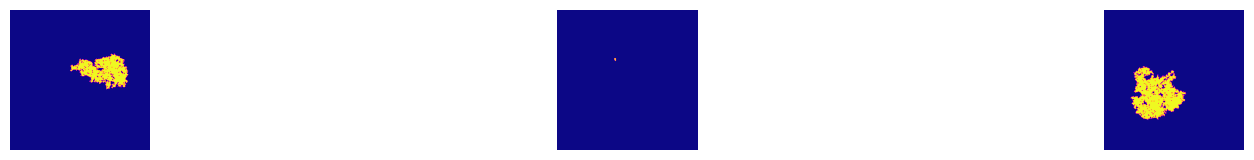

In [3]:
np.random.seed(42)
nDisplay = 3
randomIndex = np.random.randint(0, np.shape(trainx)[0], nDisplay)
plt.figure(figsize =(20,4))
print(randomIndex)
for i in range(nDisplay):
  plt.subplot(2, nDisplay, i + 1)
  plt.imshow(trainx[randomIndex[i],:,:], cmap = 'plasma')
  plt.axis('off')

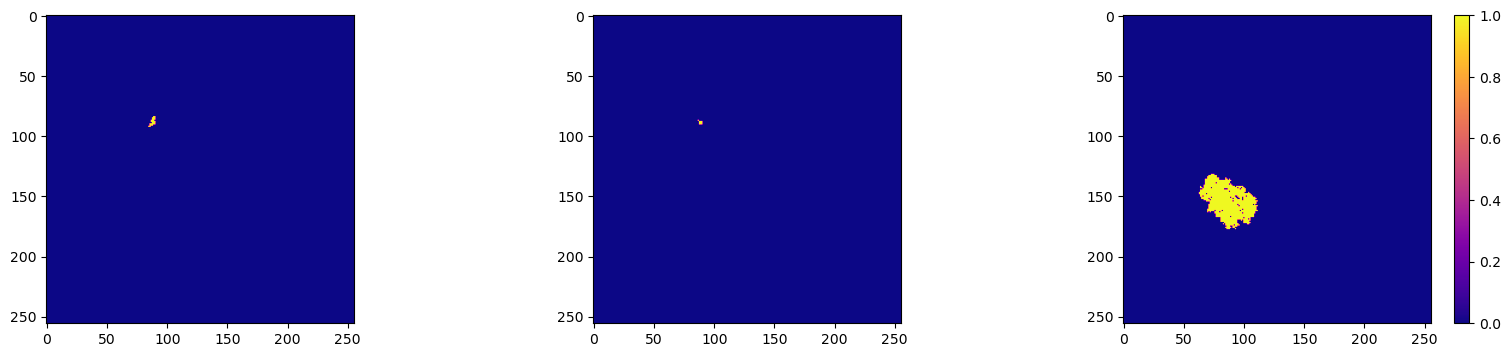

In [4]:

plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.imshow(trainx[105, :, :], cmap='plasma')

plt.subplot(1, 3, 2)
plt.imshow(trainx[15, :, :], cmap='plasma')

plt.subplot(1, 3, 3)
plt.imshow(trainx[10125, :, :], cmap='plasma')
plt.colorbar()
plt.show()


From looking at a few of these images, it is clear that a convolutional autenencoder is the best option for compressing this data it is the shape that is the most important part of the data set. The data is binary this suggests that the autoencoder will need a sigmoid activation at the end of the decoder so that the reconstructed image will be made of pixels equal to 0 or 1.

Initially i tried a basic linear autencoder to have a starting off point.

In [5]:
"""class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

shape = test_1D.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())"""

"class Autoencoder(Model):\n  def __init__(self, latent_dim, shape):\n    super(Autoencoder, self).__init__()\n    self.latent_dim = latent_dim\n    self.shape = shape\n    self.encoder = tf.keras.Sequential([\n      layers.Flatten(),\n      layers.Dense(latent_dim, activation='relu'),\n    ])\n    self.decoder = tf.keras.Sequential([\n      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),\n      layers.Reshape(shape)\n    ])\n\n  def call(self, x):\n    encoded = self.encoder(x)\n    decoded = self.decoder(encoded)\n    return decoded\n\nshape = test_1D.shape[1:]\nlatent_dim = 64\nautoencoder = Autoencoder(latent_dim, shape)\nautoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())"

Due to the issue of this linear encoder not collecting the features and shapes of the data I thought it would not be as effective as a convolutional autoencoder, which is the autoencoder I ended up using

In [6]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder layers
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(256, 256, 1)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.AveragePooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.AveragePooling2D((2, 2)),
            layers.Conv2D(122, (3, 3), activation='relu', padding='same'),
            layers.AveragePooling2D((2, 2)),
            layers.Conv2D(244, (3, 3), activation='relu', padding='same'),
            layers.AveragePooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(latent_dim)
        ])
        
        # Decoder layers
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(units=16*16*244, activation='relu'),
            layers.Reshape(target_shape=(16, 16, 244)),
            layers.Conv2DTranspose(122, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        print("Input shape:", x.shape)
        print("Encoded shape:", encoded.shape)
        print("Decoded shape:", decoded.shape)
        return decoded

# Instantiate the autoencoder
latent_dim = 128  # Adjust latent dimension as needed
autoencoder = Autoencoder(latent_dim)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


"""
training the model and saving the weights
history = autoencoder.fit(TrainX, TrainX, epochs=5, shuffle=True, validation_data=(val, val))

autoencoder.save_weights('model3.weights.h5')

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


"""

c:\Users\iyc23\AppData\Local\miniconda3\envs\bigdata\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


"\ntraining the model and saving the weights\nhistory = autoencoder.fit(TrainX, TrainX, epochs=5, shuffle=True, validation_data=(val, val))\n\nautoencoder.save_weights('model3.weights.h5')\n\nplt.plot(history.history['loss'], label='Training Loss')\nplt.plot(history.history['val_loss'], label='Validation Loss')\nplt.title('Autoencoder Loss')\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.legend()\nplt.show()\n\n\n"

In my design of the autoencoder, I had multiple convolutional layers and pooling layers, aiming to significantly reduce the dimensionality. I chose average pooling instead of max pooling as I thought it would be better as max pooling may be bias towards the burnt areas as even if there is one cell equal to 1 in the kernal then that would be the given value for the area instead avarage pooing will chose the most comon value. The final layer in the encoder is a fully connected layer the aims to finally convert the 3 dimensional data into one dimensional so that it would be fit for the data assimilation.

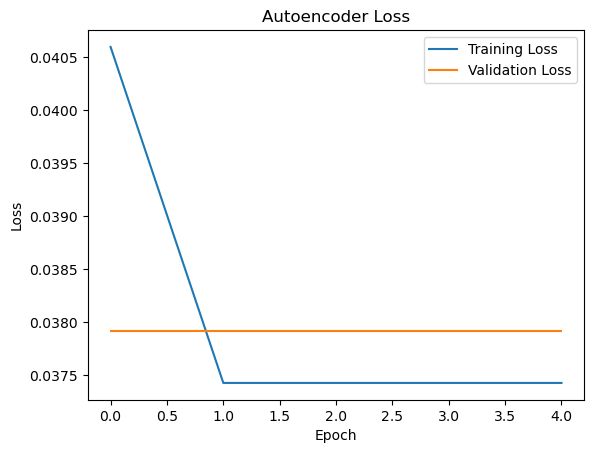

In [7]:
model = Autoencoder(latent_dim=128)
model.load_weights('model3.weights.h5')

In [8]:
s1 =time.time()
decoded_test =model.predict(test)
decodedT =np.squeeze(decoded_test, axis=-1)
new_test =np.reshape(decodedT, (np.shape(decodedT)[0],np.shape(decodedT)[1]*np.shape(decodedT)[2]))
mse =mean_squared_error(test_1D,new_test)
e1=time.time()
print('mse',mse)
print('time', e1-s1)

Input shape: (32, 256, 256)
Encoded shape: (32, 128)
Decoded shape: (32, 256, 256, 1)
122/157 ━━━━━━━━━━━━━━━━━━━━ 13s 389ms/step

KeyboardInterrupt: 

Results:<br>
mse 0.03520714<br>
time 0.08394582<br>